# 18-1. 프로젝트



## 자율주행 보조 시스템 만들기
- 위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

- 입력으로 이미지 경로를 받습니다.
- 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
- 조건은 다음과 같습니다.
    - 사람이 한 명 이상 있는 경우
    - 차량의 크기(width or height)가 300px이상인 경우
    
    
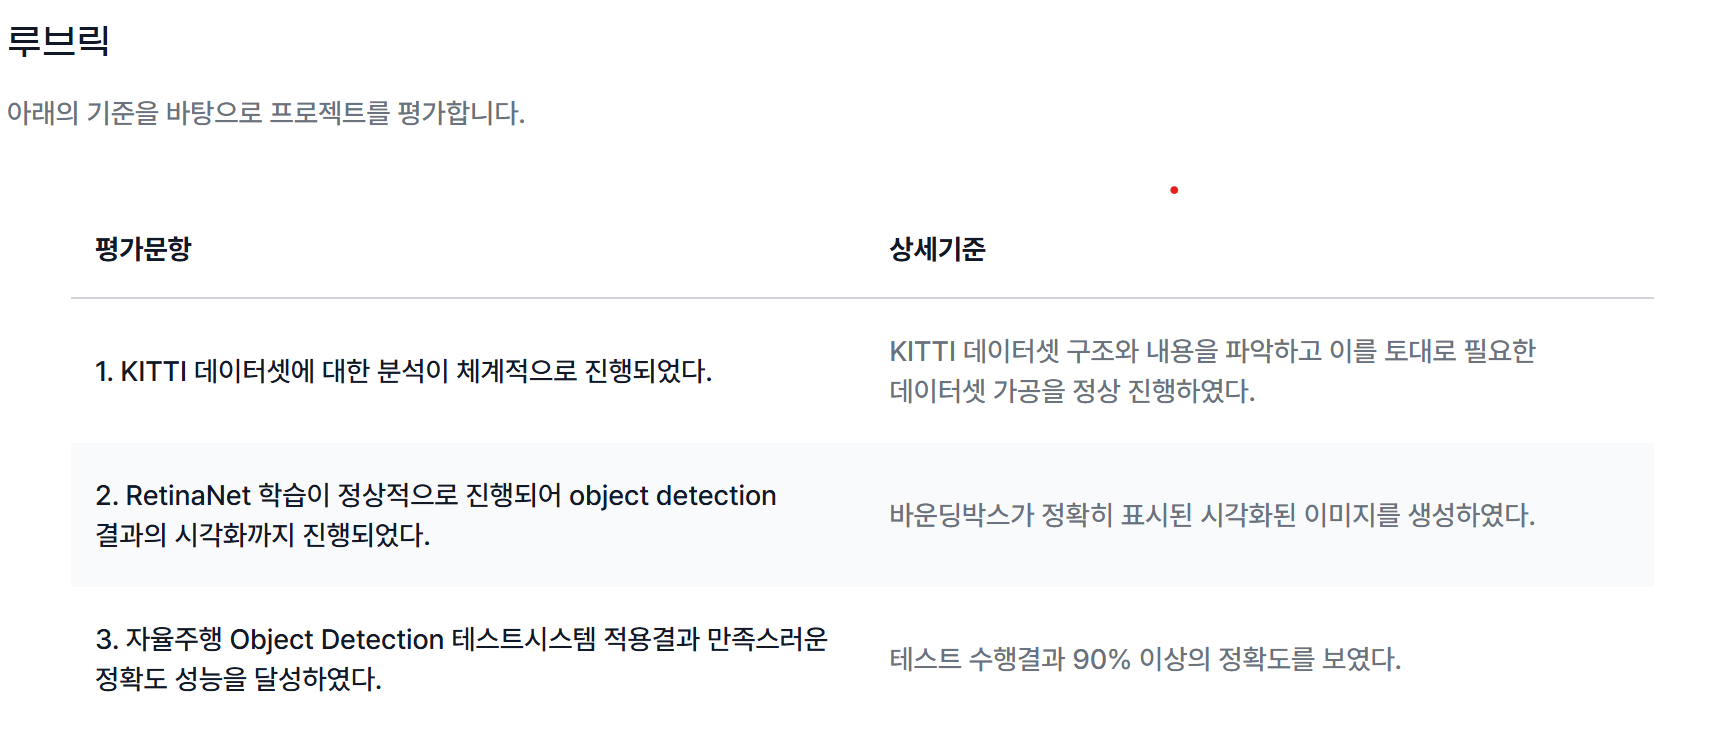

In [1]:
import tensorflow as tf

print(tf.__version__)

2.6.0


## 1. KITTI 데이터셋 가져오기

In [2]:
import os, copy
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

#### 훈련용, 테스트용 데이터 로드

In [3]:
DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

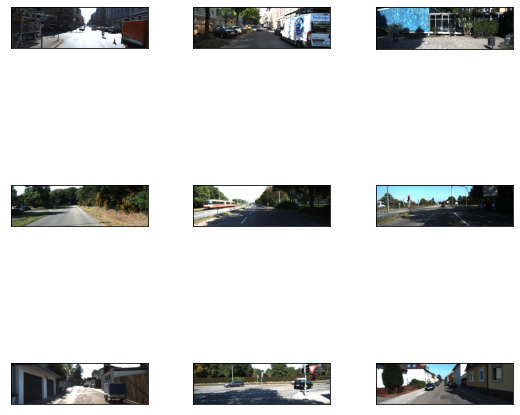

In [4]:
_ = tfds.show_examples(ds_train, ds_info)

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

## 2) KITTI 데이터 직접 확인하기
 - ds_train.take(1)을 통해서 데이터셋을 하나씩 뽑아볼 수 있는 sample을 얻을 수 있습니다. 
 - 뽑은 데이터에는 image 등의 정보가 포함
 - 이미지와 라벨을 얻는 방법임!!!!!
 
 
 ###  'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
 ###  'bbox': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.44957334, 0.6630193 , 0.53458667, 0.73496777]], dtype=float32)>,

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([2.38, 1.96, 1.7 ], dtype=float32)>, 'bbox': <tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.00266667, 0.        , 0.38368   , 0.14008051],
       [0.03472   , 0.1018277 , 0.5606933 , 0.33791465],
       [0.38629332, 0.38832527, 0.5096    , 0.44150564]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1.39, 1.48, 3.76],
       [1.81, 1.66, 4.05],
       [1.46, 1.75, 4.23]], dtype=float32)>, 'location': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[-3.67,  1.77,  2.97],
       [-3.71,  1.77,  8.72],
       [-3.29,  1.87, 25.54]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([3, 0, 0])>, 'rotation_y': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([1.53, 1.57, 1.57], dtype=float32)>, 'truncated': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.99, 0

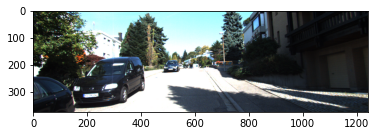

In [6]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

#### 이미지의 바운딩 박스(bounding box, bbox)를 확인하기?
 - 이미지 위에 바운딩 박스를 그려서 시각화해 보자!!!

In [7]:
print(objects['bbox'])  # objects의 내용을 확인
print(type(objects['bbox']))  # objects의 자료형 확인
# print('bbox:', objects['bbox'])
# print('bbox_xmin:', objects['bbox'].numpy()[:,1])
# print('bbox_xmax:', objects['bbox'].numpy()[:,3])
# print('bbox_ymin:', objects['bbox'].numpy()[:,0])
# print('bbox_ymax:', objects['bbox'].numpy()[:,2])


tf.Tensor(
[[0.00266667 0.         0.38368    0.14008051]
 [0.03472    0.1018277  0.5606933  0.33791465]
 [0.38629332 0.38832527 0.5096     0.44150564]], shape=(3, 4), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [8]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    # [[YOUR CODE]]
    image_width, image_height = input_image.size  # 이미지 크기
    # objects 데이터내 bbox 추출
    bbox_array = object_bbox.numpy()
    
    for bbox in bbox_array:
        xmin = int(bbox[0] * image_width)
        print(bbox[0])
        ymin = int(bbox[1] * image_height)
        xmax = int(bbox[2] * image_width)
        ymax = int(bbox[3] * image_height)
        
#         xmin, ymin, xmax, ymax = bbox
#         w = xmax-xmin
#         h = ymax-ymin        
 
        # 바운딩 박스 그리기
        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)
    
    return input_image



0.0026666666
0.03472
0.38629332


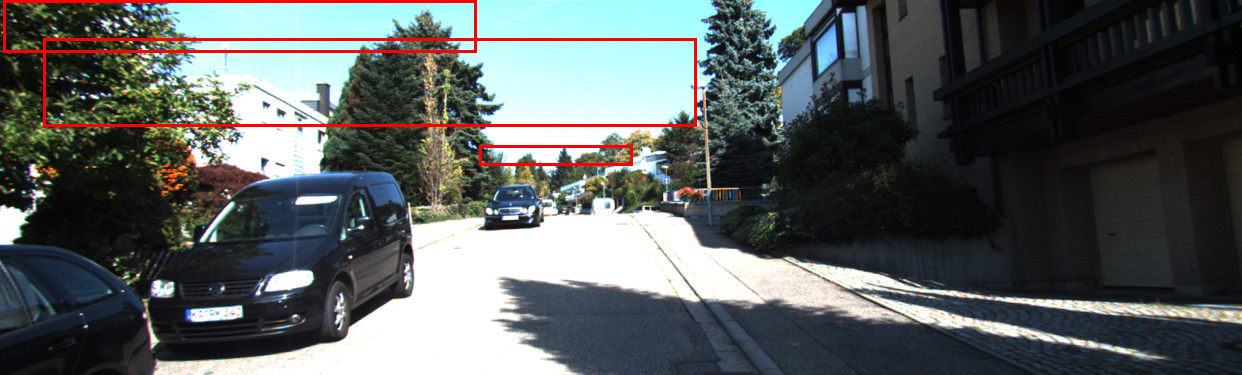

In [9]:
visualized_image = visualize_bbox(img, objects['bbox'])
visualized_image.show() 

### 바운딩 박스를 좌표에 따라 그리니 다른곳에 그리고 있음
### KITTI 데이터 셋의 bbox데이터의 의미를 알아야 함!!!!

In [10]:
# 'objects['bbox']'가 한 이미지의 바운딩 박스 데이터를 포함하고 있다고 가정
num_bboxes = len(objects['bbox'])  # 바운딩 박스의 개수 세기
print(f"이 이미지의 바운딩 박스 개수: {num_bboxes}")

이 이미지의 바운딩 박스 개수: 3


### bbox[:,0] -> xmin이 아니였어!!!!! object_bbox[:,1] * width-> xmin이야!!!!

(1242, 375)


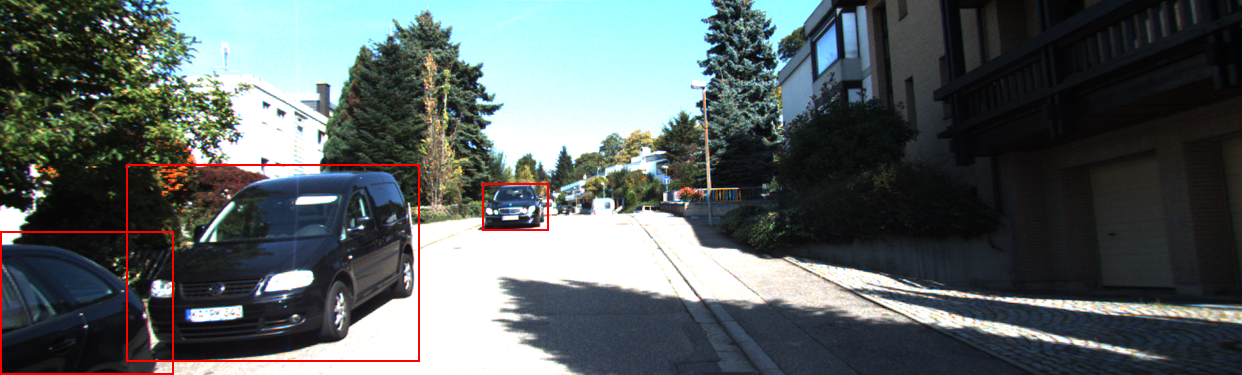

In [11]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print(img.size) # width : 1242, height: 375
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

#### 이미지 크기를 통해 width, height값을 알게 됨.
#### bbox내 데이터에 적용하여 xmin, xmax, ymin, ymax를 구함
- ymin = height - (object_bbox[:,0]*height)
- xmin = object_bbox[:,1]*width
- ymax = height - (object_bbox[:,2]*height)
- xmax = object_bbox[:,3]*width

## 2. Retina Net 모델 사용하여 학습하기
- 1-stage detector 모델인 YOLO와 SSD는 2-stage detector인 Faster-RCNN 등보다 속도는 빠르지만 성능이 낮음
- 이를 해결하기 위해서 RetinaNet에서는 focal loss와 FPN(Feature Pyramid Network) 를 적용한 네트워크를 사용
- Focal loss는 기존의 1-stage detection 모델들(YOLO, SSD)이 물체 전경과 배경을 담고 있는 모든 그리드(grid)에 대해 한 번에 학습됨으로 인해서 생기는 클래스 간의 불균형을 해결하고자 도입됨

### 2-1) Focal Loss
- 물체를 배경보다 더 잘 학습하자 == 물체인 경우 Loss를 작게 만들자


### 2-2) 데이터 파이프 라인 4단계
- 먼저 주어진 KITTI 데이터를 학습에 맞는 형태로 바꾸어 주어야 합니다.
- 데이터 파이프라인은 총 4단계로 이루어집니다.
    - x와 y좌표 위치 교체
    - 무작위로 수평 뒤집기(Flip)
    - 이미지 크기 조정 및 패딩 추가
    - 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정

#### 1단계. x와 y좌표 위치 교체

In [12]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

print('슝=3')

슝=3


#### 2단계. 무작위로 수평 뒤집기(Flip)

In [13]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

print('슝=3')

슝=3


#### 3단계. 이미지 크기 조정 및 패딩 추가

- 이미지 크기를 바꿀 때는 고려할 점이 있습니다. 
- 이미지의 비율은 그대로 유지되어야 하고, 
- 이미지의 최대/최소 크기도 제한해야 하거든요. 
- 또 이미지의 크기를 바꾼 후에도 최종적으로 모델에 입력되는 이미지의 크기는 stride의 배수가 되도록 만들 거예요.

- 예를 들어 600x720 크기의 이미지가 있다면 800x960 크기로 바꿀 수 있습니다. 
- 여기에 stride를 128로 놓아 800x960 크기의 이미지에 패딩을 더해 
- 896x1024 크기의 이미지로 모델에 입력하겠다는 이야깁니다

In [14]:
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

print('슝=3')

슝=3


#### 4단계. 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정

In [15]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

print('슝=3')

슝=3


### 2-3) 준비된 위 4단계의 함수들을 연결해 줍니다.

In [16]:
def preprocess_data(sample):
    image = sample["image"]
    # 1단계
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)
    # 2단계
    image, bbox = random_flip_horizontal(image, bbox)
    # 3단계
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    # 4단계
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

print('슝=3')

슝=3


### 2-4) 인코딩
- One stage detector에서는 Anchor Box라는 정해져 있는 위치, 크기, 비율 중에 하나로 물체의 위치가 결정됩니다. 
- 그래서 기본적으로 Anchor Box를 생성해줘야 합니다. 
- Anchor Box로 생성되는 것은 물체 위치 후보라고 생각하면 됩니다.

#### RetinaNet에서는 FPN을 사용하기 때문에 Anchor Box가 더 많이 필요합니다. 
- FPN의 각 층마다 Anchor Box가 필요하기 때문입니다. 
- RetinaNet의 FPN에서 pyramid level은 개수가 미리 약속되어 있기 때문에 각 level에서 만들어지는 Anchor Box도 약속되어 있습니다.

In [17]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

print('슝=3')

슝=3


### 2-5) IoU가 높은지 낮은지에 따라 Anchor Box가 정답인지 오답인지 체크함
- IoU를 계산할 수 있는 함수를 만듭니다.

In [18]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

print('슝=3')

슝=3


### 2-6) Anchor Box와 실제 Bounding Box의 미세한 차이를 계산합니다. 
- 상하좌우의 차이, 가로세로 크기의 차이를 기록해 두는데 가로세로 크기는 로그를 사용해서 기록해 둡니다.

In [19]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()
    
print('슝=3')

슝=3


### 2-7) 모델 작성

### 2-7-1) Feature Pyramid
 - RetinaNet에서는 FPN(Feature Pyramid Network)를 사용

In [20]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

print('슝=3')

슝=3


- Object Detection의 라벨은 class와 box로 이루어지므로 각각을 추론하는 부분이 필요합니다. 
- Backbone에 해당하는 네트워크와 FPN을 통해 pyramid layer가 추출되고 나면 그 feature들을 바탕으로 class를 예상하고, box도 예상합니다. 
- class와 box가 모두 맞을 수도, class와 box 중 하나만 맞을 수도, 둘 다 틀릴 수도 있겠죠? 
- class를 예측하는 head와 box를 예측하는 head가 별도로 존재한다!!!

#### 각각의 head를 만들어 줍니다. 
- head부분은 유사한 형태로 만들 수 있으니 build_head라는 함수를 하나만 만들고 두 번 호출하여 사용함

In [21]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

print('슝=3')

슝=3


#### RetinaNet의 backbone은 ResNet50입니다. 
#### FPN에 이용할 수 있도록 중간 레이어도 output으로 연결

In [22]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

print('슝=3')

슝=3


### 2-8) RetinaNet 구성하기
 - Backbone + FPN + classification용 head + box용 head

In [23]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

print('슝=3')

슝=3


- RetinaNet에서는  
- Classification Loss를 계산하는데만 Focal Loss 사용 
- Box Regression에는 Smooth L1 Loss를 사용

- Smooth L1 Loss을 사용하는 Box Regression에는 delta를 기준으로 계산이 달라지고,
- Focal Loss를 사용하는 Classification에서는 alpha와 gamma를 사용해서 물체일 때와 배경일 때의 식이 달라지는 점에 주의하세요!

In [24]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

print('슝=3')

슝=3


## 2-9) 모델 학습

In [25]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

print('슝=3')

94781440/94765736 [==============================] - 0s 0us/step
슝=3


- Learning Rate입니다. Learning Rate를 적절히 바꿔줍니다.
- Optimizer는 동일하게 SGD를 사용

In [26]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

- 데이터 전처리를 위한 파이프라인
- 훈련데이터, 검증데이터 준비

In [27]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

print('슝=3')

슝=3


## 2-10) Pre-trained 모델 생성

In [28]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        # 에폭마다 모델의 가중치 저장
        filepath=os.path.join(model_dir, "chekcpoints_weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 1

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)


3173/3173 [==============================] - 1687s 516ms/step - loss: 2.1410 - val_loss: 1.5626

Epoch 00001: saving model to /aiffel/aiffel/object_detection/data/chekcpoints_weights_epoch_1


In [29]:
# 모델 학습 후, 모델의 구조와 가중치를 모두 저장하는 코드
model.save_weights('final_model_weights_epoch1.h5')
model.load_weights('final_model_weights_epoch1.h5')

## 2-11. 학습결과 확인하기
- 학습결과 불러오기

In [30]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
print(latest_checkpoint)
model.load_weights(latest_checkpoint)

print('슝=3')

/aiffel/aiffel/object_detection/data/checkpoints/weights_epoch_1
슝=3


#### NMS(Non-Max Suppression)은 직접 구현하지 않고 주어진 tf.image.combined_non_max_suppression를 사용
- 'nmsed_boxes': A [batch_size, max_detections, 4] float32 tensor containing the non-max suppressed boxes.
- 'nmsed_scores': A [batch_size, max_detections] float32 tensor containing the scores for the boxes.
- 'nmsed_classes': A [batch_size, max_detections] float32 tensor containing the class for boxes.
- 'valid_detections': A [batch_size] int32 tensor indicating the number of valid detections per batch item. Only the top valid_detections[i] entries in nms_boxes[i], nms_scores[i] and nms_class[i] are valid. The rest of the entries are zero paddings.

In [31]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

print('슝=3')

슝=3


In [32]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

print('슝=3')

슝=3


### 2-12. 모델의 추론 결과 시각화 함수

In [33]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

print('슝=3')

슝=3


### 2-13. 추론을 위한 입력데이터 전처리 함수

In [34]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

print('슝=3')

슝=3


### 2-14. 학습 결과 확인

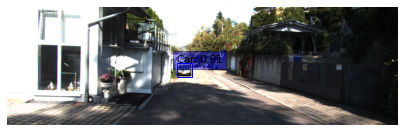

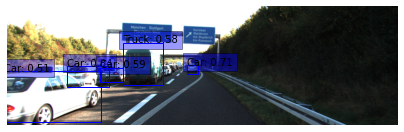

In [35]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

## 3. 자율주행 보조시스템 테스트

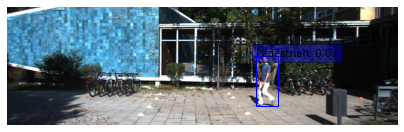

Stop


In [36]:
def self_drive_assist(img_path, size_limit=300, visualize=True):
    # 1. 이미지 로드 및 전처리
    image = tf.image.decode_png(tf.io.read_file(img_path), channels=3)
    image = tf.cast(image, dtype=tf.float32)
    input_image, ratio = prepare_image(image)

    # 2. 모델 추론
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    
    # 3. 추론 결과 분석
    classes = detections.nmsed_classes[0][:num_detections]
    boxes = detections.nmsed_boxes[0][:num_detections] / ratio
    scores = detections.nmsed_scores[0][:num_detections]

    # 클래스 이름 변환
    class_names = [int2str(int(cls)) for cls in classes]

    # 4. 정지 조건 확인
    for box, cls_name in zip(boxes, class_names):
        # 클래스가 'Person'이면 즉시 "Stop"
        if cls_name == "Pedestrian":
            if visualize:
                visualize_detections(image, boxes, class_names, scores)
            return "Stop"

        # 차량 크기(width 또는 height)가 300px 이상인 경우 "Stop"
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min

        if width >= size_limit or height >= size_limit:
            if visualize:
                visualize_detections(image, boxes, class_names, scores)
            return "Stop"

    # 정지 조건을 만족하지 않으면 "Go"
    if visualize:
        visualize_detections(image, boxes, class_names, scores)
    return "Go"

# 테스트 실행
img_path = os.getenv('HOME') + '/aiffel/object_detection/data/stop_1.png'
print(self_drive_assist(img_path))


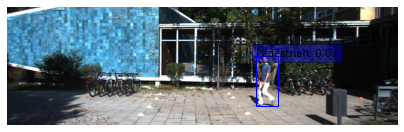

이미지 파일: stop_1.png, 결과: Stop


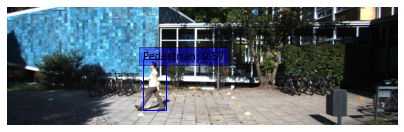

이미지 파일: stop_2.png, 결과: Stop


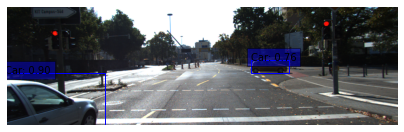

이미지 파일: stop_3.png, 결과: Stop


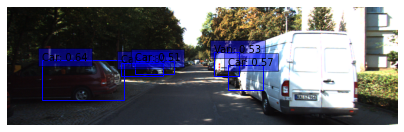

이미지 파일: stop_4.png, 결과: Go


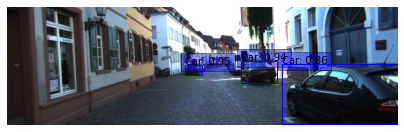

이미지 파일: stop_5.png, 결과: Stop


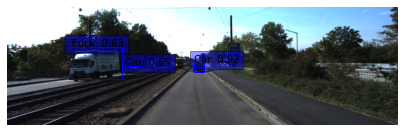

이미지 파일: go_1.png, 결과: Go


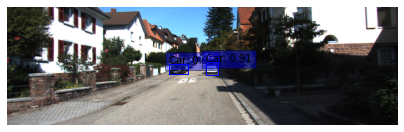

이미지 파일: go_2.png, 결과: Go


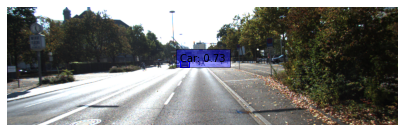

이미지 파일: go_3.png, 결과: Go


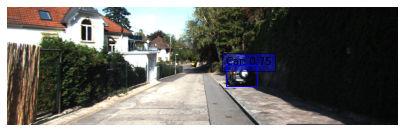

이미지 파일: go_4.png, 결과: Go


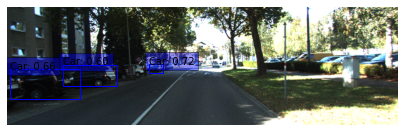

이미지 파일: go_5.png, 결과: Go


In [37]:
# 테스트할 이미지 파일 목록 생성
stop_files = [f'stop_{i}.png' for i in range(1, 6)]
go_files = [f'go_{i}.png' for i in range(1, 6)]
test_files = stop_files + go_files

# 테스트 실행
for file_name in test_files:
    img_path = os.path.join(os.getenv('HOME'), 'aiffel/object_detection/data', file_name)
    result = self_drive_assist(img_path)
    print(f"이미지 파일: {file_name}, 결과: {result}")

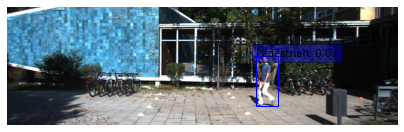

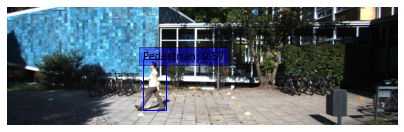

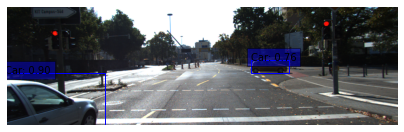

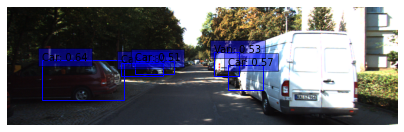

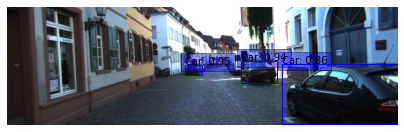

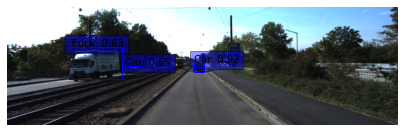

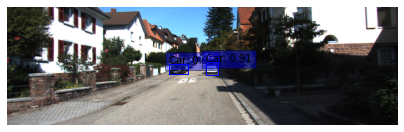

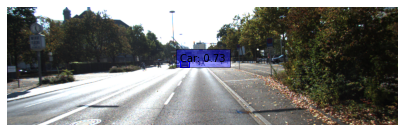

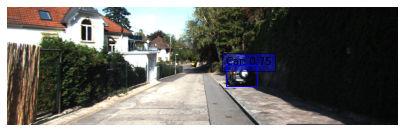

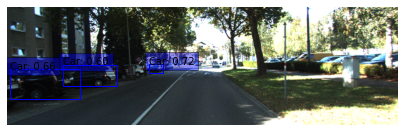

90점입니다.


In [38]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

### 회고
- 자율주행 보조 시스템의 테스트 결과, 90점/100점 이었음.
- 10장의 이미지중 1장을 틀림..하얀색 건물과 겹치게 있는 하얀색 Van을 탐지하지 못함.
- 하지만 해당 이미지의 탐지 못된 자동차는 주차되어 있는 상태로, 자율주행차가 'Go'가 가능한 상태임. 이미지 레이블은 'stop'으로 되어 있지만..
- 실시간 동영상에서는 움직이는 차인지 정차되어 있는 차인지 구분할수 있겠지...